## Лабораторная работа №3

### Задание на лабораторную работу:

Разработать собственную реализацию методов Grid Search и Random Search. Данные методы должны находить гиперпараметры модели, которые обеспечивают минимальное значение ошибки согласно варианту. Использовать наборы данных, полученные при выполнении лабораторной работы №1. Вид ошибки определяется в зависимости от варианта:

* Чётный номер варианта – ошибка первого рода
* Нечётный номер вариант – ошибка второго рода.

### Результаты, которые необходимо получить в итоге:

1. Значения гиперпараметров классификаторов (_KNeighborsClassifier_ и _DecisionTreeClassifier_).
2. Таблицу, содержащую значения F-меры, точности и полноты для каждого класса при использовании оптимальных значений параметров классификации.
3. Выводы о плюсах и минусах используемых методов поиска оптимальных параметров.


## Этапы выполнения работы:

1. Загрузим данные, которые были получены при выполнении первой лабораторной работы;
2. Напишем функции для GridSearch/RandomSearch;
3. Построем дерево решений;
4. Построем k ближайших соседей;
5. Сделаем выводы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pydot

from matplotlib.pylab import rc, plot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, accuracy_score, roc_curve
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from IPython.display import Image
from sklearn.tree import export_graphviz
from six import StringIO

%matplotlib inline
pd.get_option("display.max_columns")
warnings.filterwarnings('ignore')
RAND=7

## Загружаем данные, полученные при выполнении первой лабораторной работы

In [2]:
df = pd.read_excel("data.xlsx")

In [3]:
df.head()

first_feature  second_feature  target_value
0      -3.215031      -12.658620             6
1       1.953394        6.279312             1
2       1.574853        8.359959             5
3      14.473968       -0.218425             2
4       9.983138       -3.442013             2

In [4]:
print(f"Размерность данных: {df.shape}")

Размерность данных: (5054, 3)


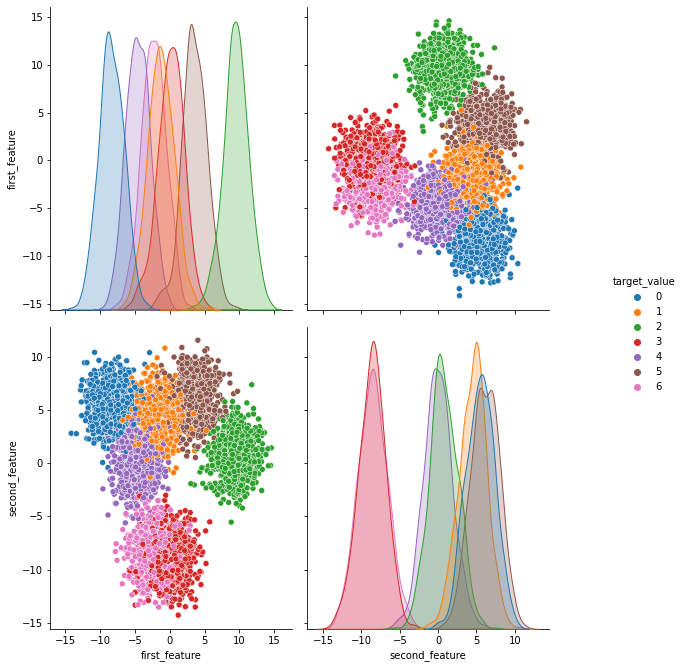

In [5]:
g = sns.pairplot(df, hue='target_value', palette="tab10")
g.fig.set_size_inches(10, 10)

## Задаем параметры для подбора гиперпараметров

In [6]:
parametrs = {
    "max_depth": np.linspace(1, 32, 32, endpoint=True),
    "min_samples_split": np.linspace(0.01, 0.1, 10, endpoint=True),
    "min_samples_leaf": np.linspace(0.01, 0.1, 10, endpoint=True)
}

In [7]:
X, y = df.drop("target_value", axis=1), df["target_value"]

## Разбиваем выборку на обучающую и тренировочную

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.55, stratify=y, random_state=RAND)

Использую refit="precision_macro", так как $precision = \frac{TP}{(TP+FP)}$, по заданию нужно минимизировать ошибку первого рода, чем меньше значение FP, тем больше значение precision, чем выще precision, тем меньше ошибка первого рода.

In [9]:
def random_search(model=None, refit="precision_macro", params=parametrs, X=X, y=y): 
    random_search_cv = RandomizedSearchCV(
        model, 
        params, 
        scoring=["f1_macro", "precision_macro", "recall_macro"], 
        n_jobs=-1, 
        cv=StratifiedKFold(n_splits=5, random_state=RAND, shuffle=True), 
        verbose=3, 
        refit=refit
    )
    random_search = random_search_cv.fit(X, y)
    print(f"Best params for {refit}")
    print(random_search.best_params_)

In [10]:
def grid_search(model=None, refit="precision_macro", params=parametrs, 
                   X_train=X_train, y_train=y_train, X_test=X_test):
    grid_search = GridSearchCV(
        model, 
        params, 
        scoring=['f1_macro','precision_macro', 'recall_macro'], 
        n_jobs=4, 
        cv=StratifiedKFold(n_splits=5, random_state=RAND, shuffle=True), 
        verbose=3,
        refit=refit
    ) 
    grid_search.fit(X_train.values, y_train.values)
    y_pred = grid_search.predict(X_test.values)
    print(f"Best params for {refit}")
    print(grid_search.best_params_)

In [11]:
def print_result(y_test=y_test, pred=None):
    print(f"Classification report: \n {classification_report(y_test, pred)}")
    print(f"Confusion matrix: \n {confusion_matrix(y_test, pred)} \n")
    sns.set(font_scale=0.8)
    sns.heatmap(confusion_matrix(y_test, pred), linewidths=.5, cmap="mako", annot=True)

## Decision Tree Classfier

In [12]:
dtc = DecisionTreeClassifier(random_state=42)
score = cross_val_score(dtc, X, y, cv=9, scoring="precision_macro")
print(f"Average precision score without setting hyperparameters: {score.mean() * 100:.2f}%")

Average precision score without setting hyperparameters: 81.53%


Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       397
           1       0.74      0.76      0.75       397
           2       0.99      0.96      0.98       397
           3       0.66      0.68      0.67       397
           4       0.83      0.81      0.82       398
           5       0.86      0.87      0.87       397
           6       0.65      0.64      0.65       397

    accuracy                           0.81      2780
   macro avg       0.81      0.81      0.81      2780
weighted avg       0.81      0.81      0.81      2780

Confusion matrix: 
 [[366  15   0   0  16   0   0]
 [ 11 302   1   0  38  45   0]
 [  0   2 383   3   0   9   0]
 [  0   1   0 269   1   0 126]
 [ 31  38   0   0 321   0   8]
 [  0  48   4   0   1 344   0]
 [  0   0   0 135   8   0 254]] 



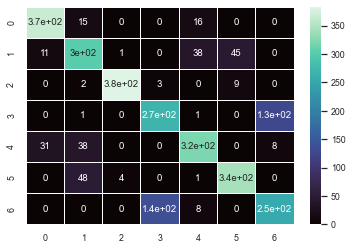

In [13]:
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)
print_result(y_test=y_test, pred=pred)

## Random search

In [14]:
%%time
random_search(model=dtc, refit="precision_macro", params=parametrs, X=X, y=y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for precision_macro
{'min_samples_split': 0.01, 'min_samples_leaf': 0.08, 'max_depth': 10.0}
CPU times: user 123 ms, sys: 136 ms, total: 258 ms
Wall time: 1.37 s


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedM

RandomSearchCV дал следующие значения гиперпараметров:

{'min_samples_split': 0.01, 'min_samples_leaf': 0.08, 'max_depth': 10.0}

In [15]:
dtc_random = DecisionTreeClassifier(
    random_state=RAND, 
    max_depth=10.0, 
    min_samples_leaf=0.08, 
    min_samples_split=0.01
)

In [16]:
score = cross_val_score(dtc_random, X, y, cv=9, scoring="precision_macro")
print(f"Average precision score with RandomSearch hyperparameter settings: {np.mean(score) * 100:.2f}%")

Average precision score with RandomSearch hyperparameter settings: 84.19%


Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       397
           1       0.82      0.79      0.80       397
           2       0.94      0.94      0.94       397
           3       0.72      0.74      0.73       397
           4       0.88      0.84      0.86       398
           5       0.84      0.85      0.85       397
           6       0.73      0.71      0.72       397

    accuracy                           0.83      2780
   macro avg       0.83      0.83      0.83      2780
weighted avg       0.83      0.83      0.83      2780

Confusion matrix: 
 [[379   8   0   0  10   0   0]
 [ 13 312   0   0  31  41   0]
 [  0   0 372   3   0  22   0]
 [  0   0   0 295   3   0  99]
 [ 30  26   0   0 336   0   6]
 [  0  36  22   0   0 339   0]
 [  0   0   0 113   3   0 281]] 



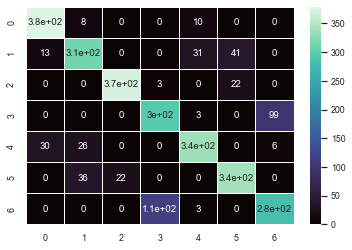

In [17]:
dtc_random.fit(X_train, y_train)
pred_random_search = dtc_random.predict(X_test)
print_result(y_test=y_test, pred=pred_random_search)

## Визуализируем дерево решений, полученное с настройкой гиперпараметров RandomSearchCV:

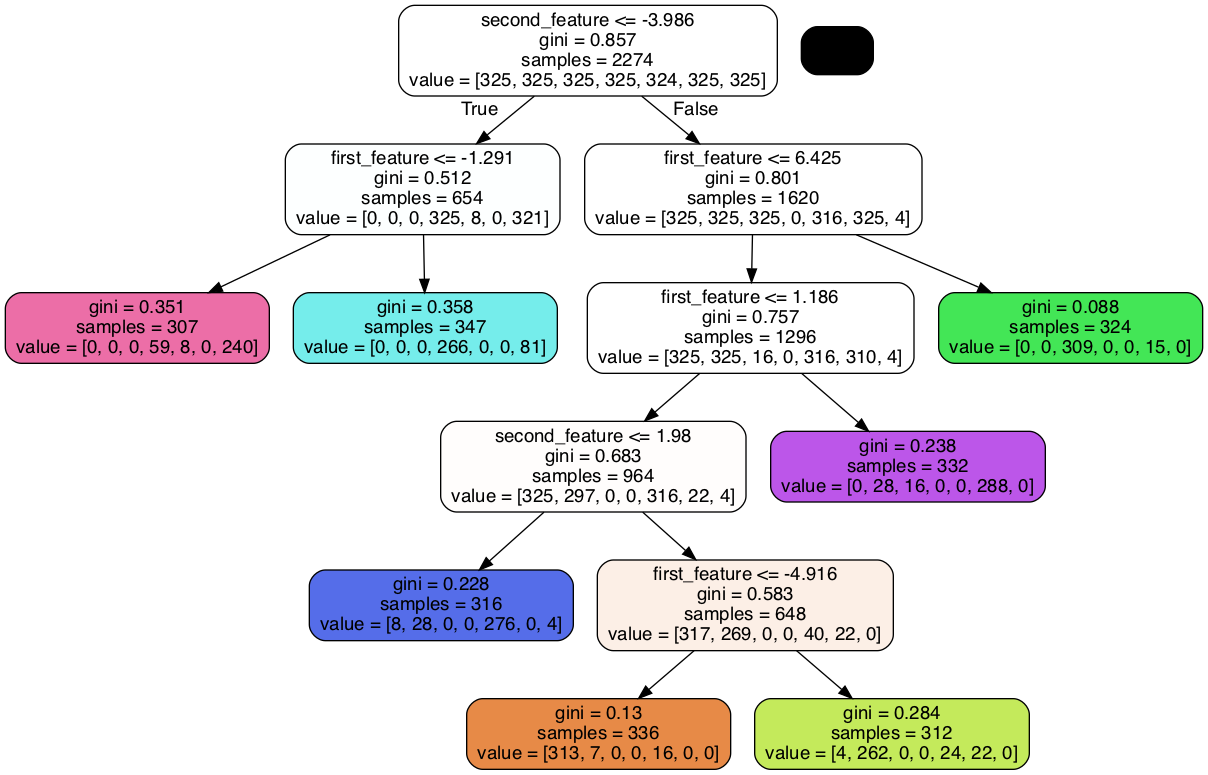

In [18]:
features = list(X.columns)
dot_data = StringIO()
export_graphviz(dtc_random, out_file=dot_data, feature_names=features, filled=True, rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

Дерево решений порой используется для того, чтобы отобрать информативные признаки. Признаки в верхних листьях являются наиболее информативными. Из визуализации можно сказать, что самый верхний лист соотвествует сравнению признака first_feature с числом, исходя их этого можно сказать, что признак first_feature важнее признака second_feature.

In [19]:
max_depth = np.linspace(1, 32, 32, endpoint=True)
min_samples_split = np.linspace(0.01, 0.1, 10, endpoint=True)
min_samples_leaf = np.linspace(0.01, 0.1, 10, endpoint=True)

## Функция для отрисовки графиков

In [20]:
def plot_valid_train(train_scores, valid_scores, param):
    train_mean=np.mean(train_scores, axis=1)
    train_std=np.std(train_scores, axis=1)
    valid_scores_mean=np.mean(valid_scores, axis=1)
    valid_scores_std=np.std(valid_scores, axis=1)
    plt.plot(param, train_mean, label="Training score", color='black')
    plt.plot(param, valid_scores_mean, label="Cross-validation score", color="dimgrey")
    plt.fill_between(param, train_mean-train_std, train_mean+train_std, color="gray")
    plt.fill_between(param, valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color="gainsboro")
    plt.title("Validation curve")
    plt.ylabel("Precision core")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()

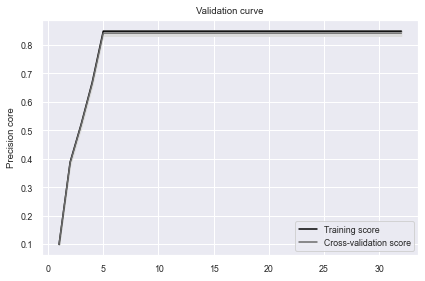

In [21]:
train_scores, valid_scores = validation_curve(
    dtc_random, X, y, 
    param_name="max_depth", 
    param_range=max_depth, 
    scoring="precision_macro",
    cv=9
)

plot_valid_train(train_scores, valid_scores, max_depth)

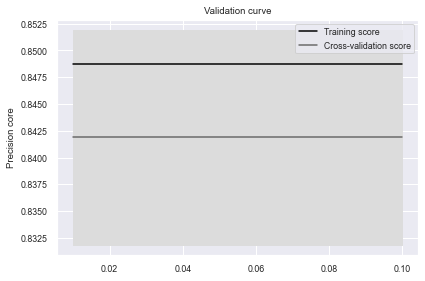

In [22]:
train_scores, valid_scores = validation_curve(
    dtc_random, X, y, 
    param_name="min_samples_split", 
    param_range=min_samples_split,
    scoring="precision_macro", 
    cv=9
)

plot_valid_train(train_scores, valid_scores, min_samples_split)

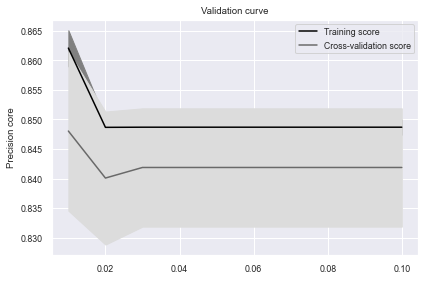

In [23]:
train_scores, valid_scores = validation_curve(
    dtc_random, X, y, 
    param_name="min_samples_leaf",
    param_range=min_samples_leaf, 
    scoring="precision_macro", cv=9
)

plot_valid_train(train_scores, valid_scores, min_samples_leaf)

На всех графиках видно, что прямые примерно параллельны, также ошибка на train всегда меньше, чем в результате CV, но большой разницы между ними нет. Можно утверждать, что переобучения нет.

## Grid Search for Decision Tree Classifier

In [24]:
%%time
grid_search(model=dtc, refit="precision_macro", params=parametrs, X_train=X_train, y_train=y_train, X_test=X_test)

[CV 2/5] END max_depth=22.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.030000000000000006; f1_macro: (test=0.822) precision_macro: (test=0.825) recall_macro: (test=0.824) total time=   0.0s
[CV 3/5] END max_depth=9.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.01; f1_macro: (test=0.843) precision_macro: (test=0.844) recall_macro: (test=0.844) total time=   0.0s
[CV 4/5] END max_depth=21.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.04000000000000001; f1_macro: (test=0.853) precision_macro: (test=0.857) recall_macro: (test=0.854) total time=   0.0s
[CV 5/5] END max_depth=10.0, min_samples_leaf=0.08, min_samples_split=0.01; f1_macro: (test=0.822) precision_macro: (test=0.825) recall_macro: (test=0.822) total time=   0.0s
[CV 5/5] END max_depth=29.0, min_samples_leaf=0.1, min_samples_split=0.04000000000000001; f1_macro: (test=0.822) precision_macro: (test=0.825) recall_macro: (test=0.822) total time=   0.0s
[CV 4/5] END max_depth=9.0, min_sa

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedM

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedM

[CV 4/5] END max_depth=1.0, min_samples_leaf=0.01, min_samples_split=0.01; f1_macro: (test=0.142) precision_macro: (test=0.100) recall_macro: (test=0.286) total time=   0.0s
[CV 2/5] END max_depth=1.0, min_samples_leaf=0.01, min_samples_split=0.06000000000000001; f1_macro: (test=0.143) precision_macro: (test=0.100) recall_macro: (test=0.286) total time=   0.0s
[CV 3/5] END max_depth=1.0, min_samples_leaf=0.01, min_samples_split=0.06000000000000001; f1_macro: (test=0.143) precision_macro: (test=0.100) recall_macro: (test=0.286) total time=   0.0s
[CV 2/5] END max_depth=1.0, min_samples_leaf=0.01, min_samples_split=0.08; f1_macro: (test=0.143) precision_macro: (test=0.100) recall_macro: (test=0.286) total time=   0.0s
[CV 3/5] END max_depth=1.0, min_samples_leaf=0.01, min_samples_split=0.08; f1_macro: (test=0.143) precision_macro: (test=0.100) recall_macro: (test=0.286) total time=   0.0s
[CV 4/5] END max_depth=1.0, min_samples_leaf=0.01, min_samples_split=0.08; f1_macro: (test=0.142) pr

ior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-

[CV 2/5] END max_depth=1.0, min_samples_leaf=0.07, min_samples_split=0.030000000000000006; f1_macro: (test=0.143) precision_macro: (test=0.100) recall_macro: (test=0.286) total time=   0.0s
[CV 3/5] END max_depth=1.0, min_samples_leaf=0.07, min_samples_split=0.030000000000000006; f1_macro: (test=0.143) precision_macro: (test=0.100) recall_macro: (test=0.286) total time=   0.0s
[CV 4/5] END max_depth=1.0, min_samples_leaf=0.07, min_samples_split=0.030000000000000006; f1_macro: (test=0.142) precision_macro: (test=0.100) recall_macro: (test=0.286) total time=   0.0s
[CV 5/5] END max_depth=1.0, min_samples_leaf=0.07, min_samples_split=0.030000000000000006; f1_macro: (test=0.142) precision_macro: (test=0.098) recall_macro: (test=0.286) total time=   0.0s
[CV 1/5] END max_depth=1.0, min_samples_leaf=0.07, min_samples_split=0.04000000000000001; f1_macro: (test=0.143) precision_macro: (test=0.100) recall_macro: (test=0.286) total time=   0.0s
[CV 2/5] END max_depth=1.0, min_samples_leaf=0.07, 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedM

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedM

[CV 4/5] END max_depth=2.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.04000000000000001; f1_macro: (test=0.428) precision_macro: (test=0.406) recall_macro: (test=0.514) total time=   0.0s
[CV 5/5] END max_depth=2.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.04000000000000001; f1_macro: (test=0.421) precision_macro: (test=0.398) recall_macro: (test=0.508) total time=   0.0s
[CV 1/5] END max_depth=2.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.05000000000000001; f1_macro: (test=0.415) precision_macro: (test=0.393) recall_macro: (test=0.503) total time=   0.0s
[CV 2/5] END max_depth=2.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.05000000000000001; f1_macro: (test=0.395) precision_macro: (test=0.365) recall_macro: (test=0.490) total time=   0.0s
[CV 3/5] END max_depth=2.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.05000000000000001; f1_macro: (test=0.403) precision_macro: (test=0.386) recall_macro: (test=0

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedM

[CV 4/5] END max_depth=2.0, min_samples_leaf=0.1, min_samples_split=0.020000000000000004; f1_macro: (test=0.428) precision_macro: (test=0.406) recall_macro: (test=0.514) total time=   0.0s
[CV 5/5] END max_depth=2.0, min_samples_leaf=0.1, min_samples_split=0.020000000000000004; f1_macro: (test=0.421) precision_macro: (test=0.398) recall_macro: (test=0.508) total time=   0.0s
[CV 1/5] END max_depth=2.0, min_samples_leaf=0.1, min_samples_split=0.030000000000000006; f1_macro: (test=0.415) precision_macro: (test=0.393) recall_macro: (test=0.503) total time=   0.0s
[CV 2/5] END max_depth=2.0, min_samples_leaf=0.1, min_samples_split=0.030000000000000006; f1_macro: (test=0.395) precision_macro: (test=0.365) recall_macro: (test=0.490) total time=   0.0s
[CV 3/5] END max_depth=2.0, min_samples_leaf=0.1, min_samples_split=0.030000000000000006; f1_macro: (test=0.403) precision_macro: (test=0.386) recall_macro: (test=0.486) total time=   0.0s
[CV 4/5] END max_depth=2.0, min_samples_leaf=0.1, min_s

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedM

[CV 5/5] END max_depth=3.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.1; f1_macro: (test=0.563) precision_macro: (test=0.533) recall_macro: (test=0.640) total time=   0.0s
[CV 1/5] END max_depth=3.0, min_samples_leaf=0.07, min_samples_split=0.01; f1_macro: (test=0.552) precision_macro: (test=0.533) recall_macro: (test=0.622) total time=   0.0s
[CV 2/5] END max_depth=3.0, min_samples_leaf=0.07, min_samples_split=0.01; f1_macro: (test=0.524) precision_macro: (test=0.504) recall_macro: (test=0.596) total time=   0.0s
[CV 3/5] END max_depth=3.0, min_samples_leaf=0.07, min_samples_split=0.01; f1_macro: (test=0.537) precision_macro: (test=0.513) recall_macro: (test=0.609) total time=   0.0s
[CV 4/5] END max_depth=3.0, min_samples_leaf=0.07, min_samples_split=0.01; f1_macro: (test=0.573) precision_macro: (test=0.544) recall_macro: (test=0.648) total time=   0.0s
[CV 5/5] END max_depth=3.0, min_samples_leaf=0.07, min_samples_split=0.01; f1_macro: (test=0.563) precision_macro: (

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedM

[CV 5/5] END max_depth=4.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.1; f1_macro: (test=0.705) precision_macro: (test=0.676) recall_macro: (test=0.754) total time=   0.0s
[CV 1/5] END max_depth=4.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.01; f1_macro: (test=0.689) precision_macro: (test=0.670) recall_macro: (test=0.734) total time=   0.0s
[CV 2/5] END max_depth=4.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.01; f1_macro: (test=0.666) precision_macro: (test=0.643) recall_macro: (test=0.714) total time=   0.0s
[CV 3/5] END max_depth=4.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.01; f1_macro: (test=0.668) precision_macro: (test=0.647) recall_macro: (test=0.710) total time=   0.0s
[CV 4/5] END max_depth=4.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.01; f1_macro: (test=0.715) precision_macro: (test=0.696) recall_macro: (test=0.760) total time=   0.0s
[CV 5/5] END max_depth=4.0, min_samples_leaf=0.050000000

[CV 5/5] END max_depth=4.0, min_samples_leaf=0.1, min_samples_split=0.05000000000000001; f1_macro: (test=0.705) precision_macro: (test=0.676) recall_macro: (test=0.754) total time=   0.0s
[CV 1/5] END max_depth=4.0, min_samples_leaf=0.1, min_samples_split=0.06000000000000001; f1_macro: (test=0.689) precision_macro: (test=0.670) recall_macro: (test=0.734) total time=   0.0s
[CV 2/5] END max_depth=4.0, min_samples_leaf=0.1, min_samples_split=0.06000000000000001; f1_macro: (test=0.666) precision_macro: (test=0.643) recall_macro: (test=0.714) total time=   0.0s
[CV 3/5] END max_depth=4.0, min_samples_leaf=0.1, min_samples_split=0.06000000000000001; f1_macro: (test=0.668) precision_macro: (test=0.647) recall_macro: (test=0.710) total time=   0.0s
[CV 4/5] END max_depth=4.0, min_samples_leaf=0.1, min_samples_split=0.06000000000000001; f1_macro: (test=0.715) precision_macro: (test=0.696) recall_macro: (test=0.760) total time=   0.0s
[CV 5/5] END max_depth=4.0, min_samples_leaf=0.1, min_sample

[CV 4/5] END max_depth=5.0, min_samples_leaf=0.08, min_samples_split=0.06000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=5.0, min_samples_leaf=0.08, min_samples_split=0.06000000000000001; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=5.0, min_samples_leaf=0.08, min_samples_split=0.07; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=5.0, min_samples_leaf=0.08, min_samples_split=0.07; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=5.0, min_samples_leaf=0.08, min_samples_split=0.07; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=5.0, min_samples_leaf=0.08, min_samples_split=0.07; f1_macro: (test=0.878) pr

[CV 5/5] END max_depth=6.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.01; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=6.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.020000000000000004; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=6.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.020000000000000004; f1_macro: (test=0.830) precision_macro: (test=0.835) recall_macro: (test=0.831) total time=   0.0s
[CV 3/5] END max_depth=6.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.020000000000000004; f1_macro: (test=0.808) precision_macro: (test=0.819) recall_macro: (test=0.807) total time=   0.0s
[CV 4/5] END max_depth=6.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.020000000000000004; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time

[CV 1/5] END max_depth=6.0, min_samples_leaf=0.1, min_samples_split=0.1; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=6.0, min_samples_leaf=0.1, min_samples_split=0.1; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=6.0, min_samples_leaf=0.1, min_samples_split=0.1; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=6.0, min_samples_leaf=0.1, min_samples_split=0.1; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=6.0, min_samples_leaf=0.1, min_samples_split=0.1; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=7.0, min_samples_leaf=0.01, min_samples_split=0.01; f1_macro: (test=0.850) precision_macro: (test=0.856) recall_macro

[CV 1/5] END max_depth=7.0, min_samples_leaf=0.07, min_samples_split=0.08; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=7.0, min_samples_leaf=0.07, min_samples_split=0.08; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=7.0, min_samples_leaf=0.07, min_samples_split=0.08; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=7.0, min_samples_leaf=0.07, min_samples_split=0.08; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=7.0, min_samples_leaf=0.07, min_samples_split=0.08; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=7.0, min_samples_leaf=0.07, min_samples_split=0.09000000000000001; f1_macro: (test=0.844) precision_macro: 

[CV 3/5] END max_depth=8.0, min_samples_leaf=0.01, min_samples_split=0.1; f1_macro: (test=0.846) precision_macro: (test=0.846) recall_macro: (test=0.846) total time=   0.0s
[CV 4/5] END max_depth=8.0, min_samples_leaf=0.01, min_samples_split=0.1; f1_macro: (test=0.876) precision_macro: (test=0.880) recall_macro: (test=0.877) total time=   0.0s
[CV 5/5] END max_depth=8.0, min_samples_leaf=0.01, min_samples_split=0.1; f1_macro: (test=0.865) precision_macro: (test=0.866) recall_macro: (test=0.865) total time=   0.0s
[CV 1/5] END max_depth=8.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=8.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.837) precision_macro: (test=0.841) recall_macro: (test=0.840) total time=   0.0s
[CV 3/5] END max_depth=8.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: 

[CV 4/5] END max_depth=8.0, min_samples_leaf=0.07, min_samples_split=0.030000000000000006; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=8.0, min_samples_leaf=0.07, min_samples_split=0.030000000000000006; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=8.0, min_samples_leaf=0.07, min_samples_split=0.04000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=8.0, min_samples_leaf=0.07, min_samples_split=0.04000000000000001; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=8.0, min_samples_leaf=0.07, min_samples_split=0.04000000000000001; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=8.0, min_samples_leaf=0.07, mi

[CV 1/5] END max_depth=9.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.09000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=9.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.09000000000000001; f1_macro: (test=0.831) precision_macro: (test=0.835) recall_macro: (test=0.833) total time=   0.0s
[CV 3/5] END max_depth=9.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.09000000000000001; f1_macro: (test=0.837) precision_macro: (test=0.838) recall_macro: (test=0.837) total time=   0.0s
[CV 4/5] END max_depth=9.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.09000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=9.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.09000000000000001; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0

[CV 2/5] END max_depth=10.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.030000000000000006; f1_macro: (test=0.837) precision_macro: (test=0.841) recall_macro: (test=0.840) total time=   0.0s
[CV 3/5] END max_depth=10.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.030000000000000006; f1_macro: (test=0.837) precision_macro: (test=0.838) recall_macro: (test=0.837) total time=   0.0s
[CV 4/5] END max_depth=10.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.030000000000000006; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=10.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.030000000000000006; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=10.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.04000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro

[CV 5/5] END max_depth=10.0, min_samples_leaf=0.1, min_samples_split=0.030000000000000006; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=10.0, min_samples_leaf=0.1, min_samples_split=0.04000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=10.0, min_samples_leaf=0.1, min_samples_split=0.04000000000000001; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=10.0, min_samples_leaf=0.1, min_samples_split=0.04000000000000001; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=10.0, min_samples_leaf=0.1, min_samples_split=0.04000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=10.0, min_samples_leaf=0.1, min

[CV 5/5] END max_depth=11.0, min_samples_leaf=0.01, min_samples_split=0.1; f1_macro: (test=0.865) precision_macro: (test=0.866) recall_macro: (test=0.865) total time=   0.0s
[CV 1/5] END max_depth=11.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=11.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.837) precision_macro: (test=0.841) recall_macro: (test=0.840) total time=   0.0s
[CV 3/5] END max_depth=11.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.837) precision_macro: (test=0.838) recall_macro: (test=0.837) total time=   0.0s
[CV 4/5] END max_depth=11.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=11.0, min_samples_leaf=0.02000000000000

[CV 2/5] END max_depth=12.0, min_samples_leaf=0.01, min_samples_split=0.04000000000000001; f1_macro: (test=0.807) precision_macro: (test=0.815) recall_macro: (test=0.807) total time=   0.0s
[CV 3/5] END max_depth=12.0, min_samples_leaf=0.01, min_samples_split=0.04000000000000001; f1_macro: (test=0.846) precision_macro: (test=0.846) recall_macro: (test=0.846) total time=   0.0s
[CV 4/5] END max_depth=12.0, min_samples_leaf=0.01, min_samples_split=0.04000000000000001; f1_macro: (test=0.874) precision_macro: (test=0.877) recall_macro: (test=0.875) total time=   0.0s
[CV 5/5] END max_depth=12.0, min_samples_leaf=0.01, min_samples_split=0.04000000000000001; f1_macro: (test=0.865) precision_macro: (test=0.866) recall_macro: (test=0.865) total time=   0.0s
[CV 1/5] END max_depth=12.0, min_samples_leaf=0.01, min_samples_split=0.05000000000000001; f1_macro: (test=0.850) precision_macro: (test=0.852) recall_macro: (test=0.851) total time=   0.0s
[CV 2/5] END max_depth=12.0, min_samples_leaf=0.01

[CV 2/5] END max_depth=12.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.09000000000000001; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=12.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.09000000000000001; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=12.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.09000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=12.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.09000000000000001; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=12.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.1; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time

[CV 5/5] END max_depth=13.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.04000000000000001; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=13.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.05000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=13.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.05000000000000001; f1_macro: (test=0.837) precision_macro: (test=0.841) recall_macro: (test=0.840) total time=   0.0s
[CV 3/5] END max_depth=13.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.05000000000000001; f1_macro: (test=0.837) precision_macro: (test=0.838) recall_macro: (test=0.837) total time=   0.0s
[CV 4/5] END max_depth=13.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.05000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (t

[CV 1/5] END max_depth=14.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.030000000000000006; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=14.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.030000000000000006; f1_macro: (test=0.830) precision_macro: (test=0.835) recall_macro: (test=0.831) total time=   0.0s
[CV 3/5] END max_depth=14.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.030000000000000006; f1_macro: (test=0.808) precision_macro: (test=0.819) recall_macro: (test=0.807) total time=   0.0s
[CV 4/5] END max_depth=14.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.030000000000000006; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=14.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.030000000000000006; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (t

[CV 4/5] END max_depth=14.0, min_samples_leaf=0.09000000000000001, min_samples_split=0.07; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=14.0, min_samples_leaf=0.09000000000000001, min_samples_split=0.07; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=14.0, min_samples_leaf=0.09000000000000001, min_samples_split=0.08; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=14.0, min_samples_leaf=0.09000000000000001, min_samples_split=0.08; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=14.0, min_samples_leaf=0.09000000000000001, min_samples_split=0.08; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=14.0, min_samples_leaf=0.09

[CV 5/5] END max_depth=15.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.020000000000000004; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=15.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.030000000000000006; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=15.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.030000000000000006; f1_macro: (test=0.823) precision_macro: (test=0.830) recall_macro: (test=0.824) total time=   0.0s
[CV 3/5] END max_depth=15.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.030000000000000006; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=15.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.030000000000000006; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (t

[CV 1/5] END max_depth=15.0, min_samples_leaf=0.1, min_samples_split=0.08; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=15.0, min_samples_leaf=0.1, min_samples_split=0.08; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=15.0, min_samples_leaf=0.1, min_samples_split=0.08; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=15.0, min_samples_leaf=0.1, min_samples_split=0.08; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=15.0, min_samples_leaf=0.1, min_samples_split=0.08; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=15.0, min_samples_leaf=0.1, min_samples_split=0.09000000000000001; f1_macro: (test=0.844) precision_macro: 

[CV 2/5] END max_depth=16.0, min_samples_leaf=0.1, min_samples_split=0.01; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=16.0, min_samples_leaf=0.1, min_samples_split=0.01; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=16.0, min_samples_leaf=0.1, min_samples_split=0.01; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=16.0, min_samples_leaf=0.1, min_samples_split=0.01; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=16.0, min_samples_leaf=0.1, min_samples_split=0.020000000000000004; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=16.0, min_samples_leaf=0.1, min_samples_split=0.020000000000000004; f1_macro: (test=0.811) 

[CV 2/5] END max_depth=17.0, min_samples_leaf=0.01, min_samples_split=0.09000000000000001; f1_macro: (test=0.807) precision_macro: (test=0.815) recall_macro: (test=0.807) total time=   0.0s
[CV 3/5] END max_depth=17.0, min_samples_leaf=0.01, min_samples_split=0.09000000000000001; f1_macro: (test=0.846) precision_macro: (test=0.846) recall_macro: (test=0.846) total time=   0.0s
[CV 4/5] END max_depth=17.0, min_samples_leaf=0.01, min_samples_split=0.09000000000000001; f1_macro: (test=0.876) precision_macro: (test=0.880) recall_macro: (test=0.877) total time=   0.0s
[CV 5/5] END max_depth=17.0, min_samples_leaf=0.01, min_samples_split=0.09000000000000001; f1_macro: (test=0.865) precision_macro: (test=0.866) recall_macro: (test=0.865) total time=   0.0s
[CV 1/5] END max_depth=17.0, min_samples_leaf=0.01, min_samples_split=0.1; f1_macro: (test=0.850) precision_macro: (test=0.852) recall_macro: (test=0.851) total time=   0.0s
[CV 2/5] END max_depth=17.0, min_samples_leaf=0.01, min_samples_sp

[CV 2/5] END max_depth=17.0, min_samples_leaf=0.07, min_samples_split=0.030000000000000006; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=17.0, min_samples_leaf=0.07, min_samples_split=0.030000000000000006; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=17.0, min_samples_leaf=0.07, min_samples_split=0.030000000000000006; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=17.0, min_samples_leaf=0.07, min_samples_split=0.030000000000000006; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=17.0, min_samples_leaf=0.07, min_samples_split=0.04000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=17.0, min_samples_leaf=

[CV 5/5] END max_depth=18.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.06000000000000001; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=18.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.07; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=18.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.07; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=18.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.07; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=18.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.07; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=18.0, min_sa

[CV 4/5] END max_depth=19.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.020000000000000004; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=19.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.020000000000000004; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=19.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.030000000000000006; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=19.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.030000000000000006; f1_macro: (test=0.837) precision_macro: (test=0.841) recall_macro: (test=0.840) total time=   0.0s
[CV 3/5] END max_depth=19.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.030000000000000006; f1_macro: (test=0.837) precision_macro: (test=0.838) recall_macr

[CV 4/5] END max_depth=19.0, min_samples_leaf=0.07, min_samples_split=0.07; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=19.0, min_samples_leaf=0.07, min_samples_split=0.07; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=19.0, min_samples_leaf=0.07, min_samples_split=0.08; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=19.0, min_samples_leaf=0.07, min_samples_split=0.08; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=19.0, min_samples_leaf=0.07, min_samples_split=0.08; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=19.0, min_samples_leaf=0.07, min_samples_split=0.08; f1_macro: (test=0.878) precision_macro: (test=0.8

[CV 1/5] END max_depth=20.0, min_samples_leaf=0.08, min_samples_split=0.04000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=20.0, min_samples_leaf=0.08, min_samples_split=0.04000000000000001; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=20.0, min_samples_leaf=0.08, min_samples_split=0.04000000000000001; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=20.0, min_samples_leaf=0.08, min_samples_split=0.04000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=20.0, min_samples_leaf=0.08, min_samples_split=0.04000000000000001; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=20.0, min_samples_leaf=0.08

[CV 1/5] END max_depth=21.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.09000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=21.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.09000000000000001; f1_macro: (test=0.830) precision_macro: (test=0.835) recall_macro: (test=0.831) total time=   0.0s
[CV 3/5] END max_depth=21.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.09000000000000001; f1_macro: (test=0.828) precision_macro: (test=0.829) recall_macro: (test=0.829) total time=   0.0s
[CV 4/5] END max_depth=21.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.09000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=21.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.09000000000000001; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (t

[CV 5/5] END max_depth=22.0, min_samples_leaf=0.01, min_samples_split=0.1; f1_macro: (test=0.865) precision_macro: (test=0.866) recall_macro: (test=0.865) total time=   0.0s
[CV 1/5] END max_depth=21.0, min_samples_leaf=0.09000000000000001, min_samples_split=0.04000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=21.0, min_samples_leaf=0.09000000000000001, min_samples_split=0.04000000000000001; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=21.0, min_samples_leaf=0.09000000000000001, min_samples_split=0.04000000000000001; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=21.0, min_samples_leaf=0.09000000000000001, min_samples_split=0.04000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/

[CV 1/5] END max_depth=22.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=22.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.837) precision_macro: (test=0.841) recall_macro: (test=0.840) total time=   0.0s
[CV 3/5] END max_depth=22.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.837) precision_macro: (test=0.838) recall_macro: (test=0.837) total time=   0.0s
[CV 4/5] END max_depth=22.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=22.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=22.0, min_samples_leaf

[CV 3/5] END max_depth=23.0, min_samples_leaf=0.01, min_samples_split=0.04000000000000001; f1_macro: (test=0.846) precision_macro: (test=0.846) recall_macro: (test=0.846) total time=   0.0s
[CV 4/5] END max_depth=23.0, min_samples_leaf=0.01, min_samples_split=0.04000000000000001; f1_macro: (test=0.874) precision_macro: (test=0.877) recall_macro: (test=0.875) total time=   0.0s
[CV 5/5] END max_depth=23.0, min_samples_leaf=0.01, min_samples_split=0.04000000000000001; f1_macro: (test=0.865) precision_macro: (test=0.866) recall_macro: (test=0.865) total time=   0.0s
[CV 1/5] END max_depth=23.0, min_samples_leaf=0.01, min_samples_split=0.05000000000000001; f1_macro: (test=0.850) precision_macro: (test=0.852) recall_macro: (test=0.851) total time=   0.0s
[CV 2/5] END max_depth=23.0, min_samples_leaf=0.01, min_samples_split=0.05000000000000001; f1_macro: (test=0.807) precision_macro: (test=0.815) recall_macro: (test=0.807) total time=   0.0s
[CV 3/5] END max_depth=23.0, min_samples_leaf=0.01

[CV 2/5] END max_depth=23.0, min_samples_leaf=0.1, min_samples_split=0.08; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=23.0, min_samples_leaf=0.1, min_samples_split=0.08; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=23.0, min_samples_leaf=0.1, min_samples_split=0.08; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=23.0, min_samples_leaf=0.1, min_samples_split=0.08; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=23.0, min_samples_leaf=0.1, min_samples_split=0.09000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=23.0, min_samples_leaf=0.1, min_samples_split=0.09000000000000001; f1_macro: (test=0.811) pr

[CV 4/5] END max_depth=24.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.09000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=24.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.09000000000000001; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=24.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.1; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=24.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.1; f1_macro: (test=0.830) precision_macro: (test=0.835) recall_macro: (test=0.831) total time=   0.0s
[CV 3/5] END max_depth=24.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.1; f1_macro: (test=0.828) precision_macro: (test=0.829) recall_macro: (test=0.829) total time=   0.0s
[CV 4/5] END max_d

[CV 4/5] END max_depth=25.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.030000000000000006; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=25.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.030000000000000006; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=25.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.04000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=25.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.04000000000000001; f1_macro: (test=0.830) precision_macro: (test=0.835) recall_macro: (test=0.831) total time=   0.0s
[CV 3/5] END max_depth=25.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.04000000000000001; f1_macro: (test=0.828) precision_macro: (test=0.829) recall_macro: 

[CV 5/5] END max_depth=25.0, min_samples_leaf=0.07, min_samples_split=0.05000000000000001; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=25.0, min_samples_leaf=0.07, min_samples_split=0.06000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=25.0, min_samples_leaf=0.07, min_samples_split=0.06000000000000001; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=25.0, min_samples_leaf=0.07, min_samples_split=0.06000000000000001; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=25.0, min_samples_leaf=0.07, min_samples_split=0.06000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=25.0, min_samples_leaf=0.07

[CV 5/5] END max_depth=26.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.030000000000000006; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=26.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.04000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=26.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.04000000000000001; f1_macro: (test=0.830) precision_macro: (test=0.835) recall_macro: (test=0.831) total time=   0.0s
[CV 3/5] END max_depth=26.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.04000000000000001; f1_macro: (test=0.808) precision_macro: (test=0.819) recall_macro: (test=0.807) total time=   0.0s
[CV 4/5] END max_depth=26.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.04000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=

[CV 4/5] END max_depth=27.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.07; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=27.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.07; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=27.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.08; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=27.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.08; f1_macro: (test=0.830) precision_macro: (test=0.835) recall_macro: (test=0.831) total time=   0.0s
[CV 3/5] END max_depth=27.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.08; f1_macro: (test=0.828) precision_macro: (test=0.829) recall_macro: (test=0.829) total time=   0.0s
[CV 4/5] END max_depth=27.0, min_samples_leaf

[CV 1/5] END max_depth=27.0, min_samples_leaf=0.07, min_samples_split=0.1; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=27.0, min_samples_leaf=0.07, min_samples_split=0.1; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=27.0, min_samples_leaf=0.07, min_samples_split=0.1; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=27.0, min_samples_leaf=0.07, min_samples_split=0.1; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=27.0, min_samples_leaf=0.07, min_samples_split=0.1; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=27.0, min_samples_leaf=0.08, min_samples_split=0.01; f1_macro: (test=0.844) precision_macro: (test=0.846) r

[CV 2/5] END max_depth=28.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.05000000000000001; f1_macro: (test=0.830) precision_macro: (test=0.835) recall_macro: (test=0.831) total time=   0.0s
[CV 3/5] END max_depth=28.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.05000000000000001; f1_macro: (test=0.828) precision_macro: (test=0.829) recall_macro: (test=0.829) total time=   0.0s
[CV 4/5] END max_depth=28.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.05000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=28.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.05000000000000001; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=28.0, min_samples_leaf=0.030000000000000006, min_samples_split=0.06000000000000001; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (t

[CV 3/5] END max_depth=29.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.01; f1_macro: (test=0.808) precision_macro: (test=0.819) recall_macro: (test=0.807) total time=   0.0s
[CV 4/5] END max_depth=29.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.01; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=29.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.01; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=29.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.020000000000000004; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=29.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.020000000000000004; f1_macro: (test=0.830) precision_macro: (test=0.835) recall_macro: (test=0.831) total time=   0.0s
[CV 3/5] END max_d

[CV 4/5] END max_depth=29.0, min_samples_leaf=0.08, min_samples_split=0.07; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=29.0, min_samples_leaf=0.08, min_samples_split=0.07; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=29.0, min_samples_leaf=0.08, min_samples_split=0.08; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=29.0, min_samples_leaf=0.08, min_samples_split=0.08; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=29.0, min_samples_leaf=0.08, min_samples_split=0.08; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=29.0, min_samples_leaf=0.08, min_samples_split=0.08; f1_macro: (test=0.878) precision_macro: (test=0.8

[CV 2/5] END max_depth=30.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.837) precision_macro: (test=0.841) recall_macro: (test=0.840) total time=   0.0s
[CV 3/5] END max_depth=30.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.837) precision_macro: (test=0.838) recall_macro: (test=0.837) total time=   0.0s
[CV 4/5] END max_depth=30.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=30.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.01; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=30.0, min_samples_leaf=0.020000000000000004, min_samples_split=0.020000000000000004; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=30.0, 

[CV 3/5] END max_depth=30.0, min_samples_leaf=0.1, min_samples_split=0.01; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=30.0, min_samples_leaf=0.1, min_samples_split=0.01; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=30.0, min_samples_leaf=0.1, min_samples_split=0.01; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=30.0, min_samples_leaf=0.1, min_samples_split=0.020000000000000004; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=30.0, min_samples_leaf=0.1, min_samples_split=0.020000000000000004; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=30.0, min_samples_leaf=0.1, min_samples_split=0.020000000000000004; f1_macr

[CV 2/5] END max_depth=31.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.06000000000000001; f1_macro: (test=0.823) precision_macro: (test=0.830) recall_macro: (test=0.824) total time=   0.0s
[CV 3/5] END max_depth=31.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.06000000000000001; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=31.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.06000000000000001; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=31.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.06000000000000001; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=31.0, min_samples_leaf=0.05000000000000001, min_samples_split=0.07; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total tim

Best params for precision_macro
{'max_depth': 5.0, 'min_samples_leaf': 0.01, 'min_samples_split': 0.04000000000000001}
CPU times: user 3.4 s, sys: 424 ms, total: 3.83 s
Wall time: 14.2 s


GridSearchCV дал следующие значения гиперпараметров:

{'max_depth': 5.0, 'min_samples_leaf': 0.01, 'min_samples_split': 0.04000000000000001}

In [25]:
dtc_grid = DecisionTreeClassifier(
    random_state=42, 
    max_depth=5.0, 
    min_samples_leaf=0.01, 
    min_samples_split=0.04000000000000001
)

In [26]:
score = cross_val_score(dtc_grid, X, y, cv=9, scoring="precision_macro")
print(f"Average precision score with GridSearch hyperparameter settings: {np.mean(score) * 100:.2f}%")

Average precision score with GridSearch hyperparameter settings: 84.89%


Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       397
           1       0.78      0.83      0.81       397
           2       0.97      0.94      0.96       397
           3       0.72      0.74      0.73       397
           4       0.92      0.79      0.85       398
           5       0.85      0.89      0.87       397
           6       0.73      0.71      0.72       397

    accuracy                           0.84      2780
   macro avg       0.84      0.84      0.84      2780
weighted avg       0.84      0.84      0.84      2780

Confusion matrix: 
 [[379   8   0   0  10   0   0]
 [ 13 331   2   0  12  39   0]
 [  0   0 373   3   0  21   0]
 [  0   2   0 295   1   0  99]
 [ 30  46   0   0 316   0   6]
 [  0  36   9   0   0 352   0]
 [  0   0   0 113   3   0 281]] 



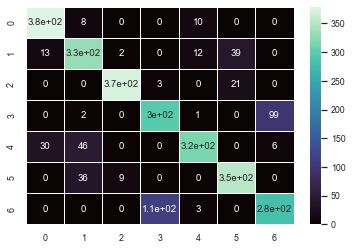

In [27]:
dtc_grid.fit(X_train, y_train)
pred_grid_search = dtc_grid.predict(X_test)
print_result(y_test, pred_grid_search)

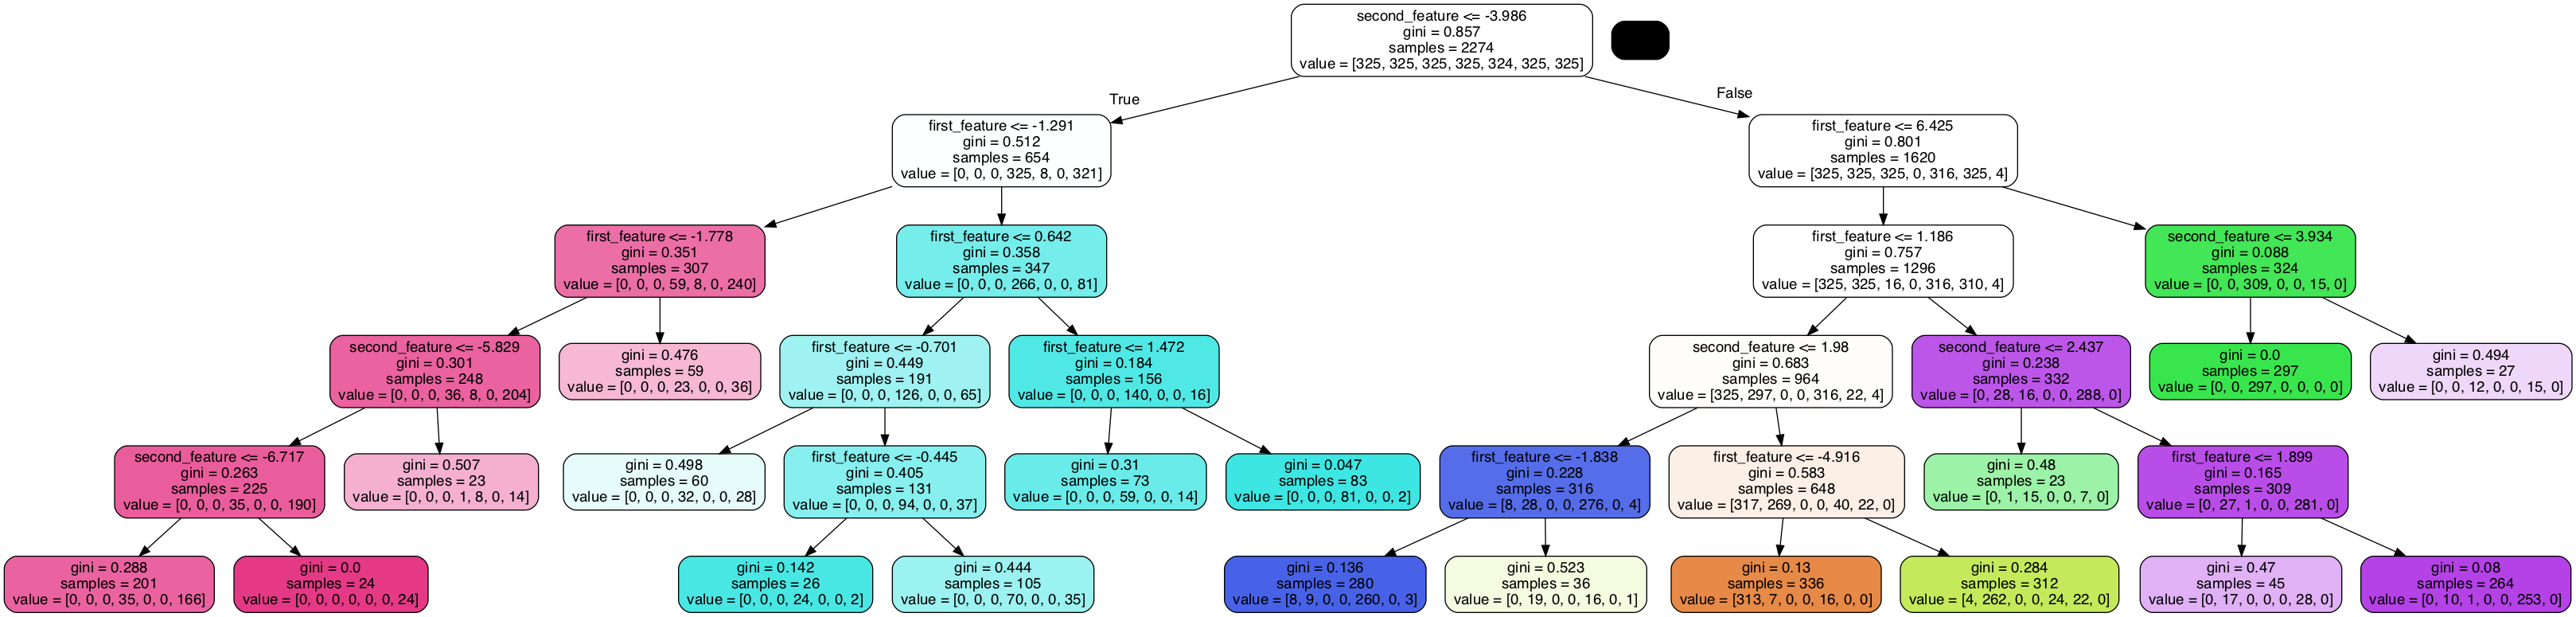

In [28]:
features = list(X.columns)
dot_data = StringIO()
export_graphviz(dtc_grid, out_file=dot_data, feature_names=features, filled=True, rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

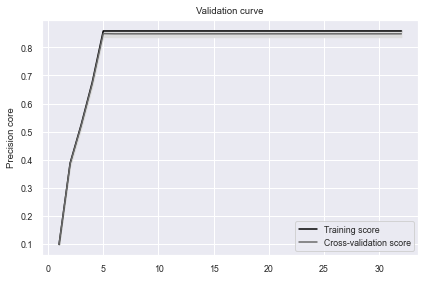

In [29]:
train_scores, valid_scores = validation_curve(
    dtc_grid, X, y, 
    param_name="max_depth",
    param_range=max_depth, 
    scoring="precision_macro", cv=9
)

plot_valid_train(train_scores, valid_scores, max_depth)

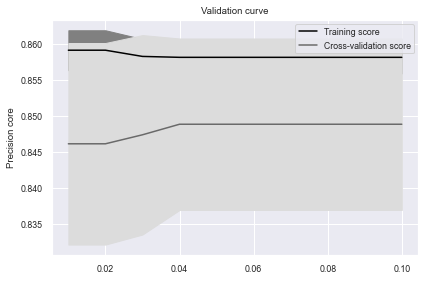

In [30]:
train_scores, valid_scores = validation_curve(
    dtc_grid, X, y, 
    param_name="min_samples_split",
    param_range=min_samples_split, 
    scoring="precision_macro", cv=9
)

plot_valid_train(train_scores, valid_scores, min_samples_split)

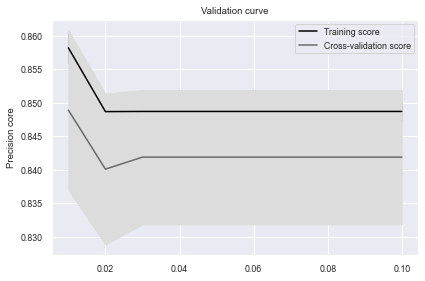

In [31]:
train_scores, valid_scores = validation_curve(
    dtc_grid, X, y, 
    param_name="min_samples_leaf",
    param_range=min_samples_leaf, 
    scoring="precision_macro", cv=9
)

plot_valid_train(train_scores, valid_scores, min_samples_leaf)

Вновь видим, что переобучения нет

# KNeighborsClassifier

In [32]:
KNeighbors = KNeighborsClassifier()
KNeighbors.fit(X_train, y_train)
KNeighborsPredict = KNeighbors.predict(X_test)

In [33]:
score = cross_val_score(KNeighbors, X, y, cv=9, scoring="precision_macro")
print(f"Average precision score without setting hyperparameters: {np.mean(score) * 100:.2f}%")

Average precision score without setting hyperparameters: 85.11%


Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       397
           1       0.83      0.80      0.81       397
           2       0.99      0.99      0.99       397
           3       0.71      0.67      0.69       397
           4       0.90      0.90      0.90       398
           5       0.88      0.90      0.89       397
           6       0.68      0.72      0.70       397

    accuracy                           0.85      2780
   macro avg       0.85      0.85      0.85      2780
weighted avg       0.85      0.85      0.85      2780

Confusion matrix: 
 [[378   8   0   0  11   0   0]
 [ 11 316   0   0  25  45   0]
 [  0   0 392   0   0   5   0]
 [  0   0   1 267   2   0 127]
 [ 13  22   0   0 357   0   6]
 [  0  35   3   0   0 359   0]
 [  0   0   0 108   3   0 286]] 



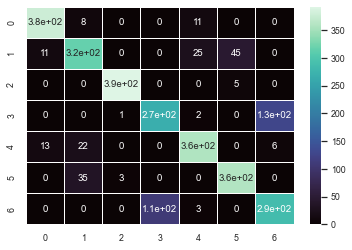

In [34]:
print_result(y_test, KNeighborsPredict)

In [35]:
parametrs = {
    "n_neighbors": np.array(range(1, 15, 1)),
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "p": [1, 2],
    "metric": ["minkowski", "euclidean", "manhattan", "chebyshev", "seuclidean", "mahalanobis"]
}

## Random Search for KNeighbors

In [36]:
%%time
random_search(model=KNeighbors, refit="precision_macro", params=parametrs, X=X, y=y)

[CV 4/5] END max_depth=32.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.1; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END max_depth=32.0, min_samples_leaf=0.06000000000000001, min_samples_split=0.1; f1_macro: (test=0.856) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 1/5] END max_depth=32.0, min_samples_leaf=0.07, min_samples_split=0.01; f1_macro: (test=0.844) precision_macro: (test=0.846) recall_macro: (test=0.844) total time=   0.0s
[CV 2/5] END max_depth=32.0, min_samples_leaf=0.07, min_samples_split=0.01; f1_macro: (test=0.811) precision_macro: (test=0.819) recall_macro: (test=0.813) total time=   0.0s
[CV 3/5] END max_depth=32.0, min_samples_leaf=0.07, min_samples_split=0.01; f1_macro: (test=0.801) precision_macro: (test=0.805) recall_macro: (test=0.800) total time=   0.0s
[CV 4/5] END max_depth=32.0, min_samples_leaf=0.07, min_samples_split=0.01; f1_macro: (test=0.878

Best params for precision_macro
{'weights': 'uniform', 'p': 1, 'n_neighbors': 9, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
CPU times: user 131 ms, sys: 104 ms, total: 235 ms
Wall time: 1.5 s


RandomSearchCV лучшие параметры для kNN:

{'weights': 'uniform', 'p': 1, 'n_neighbors': 9, 'metric': 'manhattan', 'algorithm': 'kd_tree'}

In [37]:
KNeighborsRandom = KNeighborsClassifier(
    weights="uniform", 
    p=1, 
    n_neighbors=9, 
    metric="manhattan", 
    algorithm="kd_tree"
)

KNeighborsRandom.fit(X_train, y_train)
KNeighborsRandomPredict = KNeighborsRandom.predict(X_test)
score = cross_val_score(KNeighborsRandom, X, y, cv=9, scoring='precision_macro')
print(f"Average precision score with hyperparameter setting (RandomSearchcv): {np.mean(score) * 100:.2f}%")

Average precision score with hyperparameter setting (RandomSearchcv): 85.78%


Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       397
           1       0.82      0.83      0.83       397
           2       0.99      0.98      0.99       397
           3       0.73      0.70      0.72       397
           4       0.90      0.90      0.90       398
           5       0.90      0.89      0.89       397
           6       0.71      0.74      0.72       397

    accuracy                           0.86      2780
   macro avg       0.86      0.86      0.86      2780
weighted avg       0.86      0.86      0.86      2780

Confusion matrix: 
 [[377  11   0   0   9   0   0]
 [  8 330   0   0  24  35   0]
 [  0   0 391   0   0   6   0]
 [  0   0   1 277   2   0 117]
 [ 15  20   0   0 359   0   4]
 [  0  40   3   0   0 354   0]
 [  0   0   0 100   4   0 293]] 



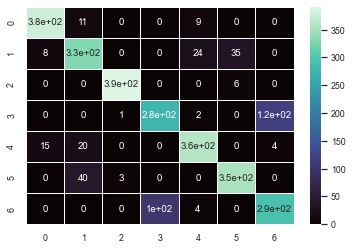

In [38]:
print_result(y_test, KNeighborsRandomPredict)

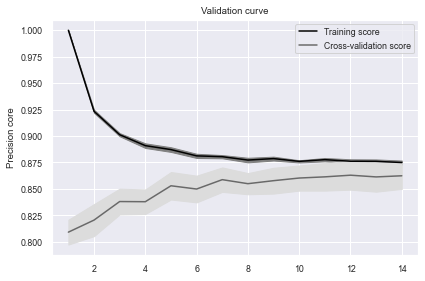

In [39]:
train_scores, valid_scores = validation_curve(
    KNeighborsRandom, X, y, 
    param_name="n_neighbors",
    param_range=parametrs["n_neighbors"], 
    cv=9, scoring="precision_macro"
)

plot_valid_train(train_scores, valid_scores, parametrs['n_neighbors'])

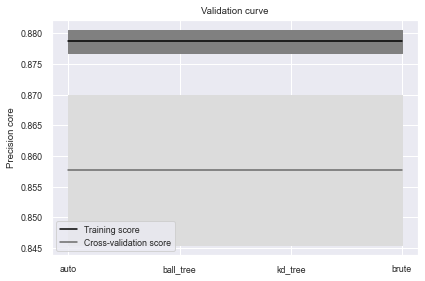

In [40]:
train_scores, valid_scores = validation_curve(
    KNeighborsRandom, X, y, 
    param_name="algorithm",
    param_range=parametrs["algorithm"], 
    cv=9, scoring="precision_macro"
)

plot_valid_train(train_scores, valid_scores, parametrs["algorithm"])

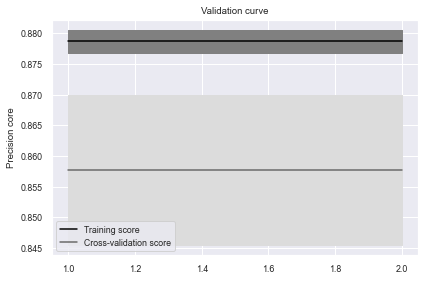

In [41]:
train_scores, valid_scores = validation_curve(
    KNeighborsRandom, X, y, 
    param_name="p",
    param_range=parametrs["p"], 
    cv=9, scoring="precision_macro"
)

plot_valid_train(train_scores, valid_scores, parametrs["p"])

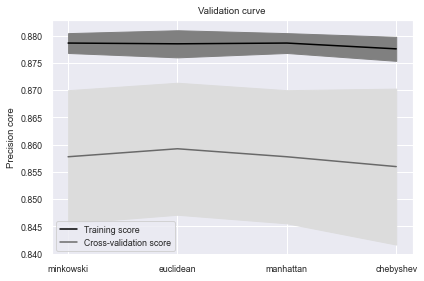

In [42]:
train_scores, valid_scores = validation_curve(
    KNeighborsRandom, X, y, 
    param_name="metric",
    param_range=parametrs["metric"], 
    cv=9, scoring="precision_macro"
)

plot_valid_train(train_scores, valid_scores, parametrs["metric"])

На графиках также не видно переобучения модели, но можно отметить, что параметры p и algoritm не оказывают влияния на качество алгоритма.

## Grid Search for KNeighbors

In [43]:
%%time
grid_search(
    model=KNeighbors, 
    refit="precision_macro", 
    params=parametrs, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test
)

[CV 5/5] END algorithm=auto, metric=euclidean, n_neighbors=12, p=2, weights=uniform; f1_macro: (test=0.855) precision_macro: (test=0.856) recall_macro: (test=0.854) total time=   0.0s
[CV 4/5] END algorithm=brute, metric=manhattan, n_neighbors=9, p=2, weights=distance; f1_macro: (test=0.869) precision_macro: (test=0.870) recall_macro: (test=0.869) total time=   0.1s
[CV 1/5] END algorithm=brute, metric=euclidean, n_neighbors=9, p=2, weights=distance; f1_macro: (test=0.856) precision_macro: (test=0.857) recall_macro: (test=0.856) total time=   0.1s
[CV 4/5] END algorithm=auto, metric=euclidean, n_neighbors=12, p=2, weights=uniform; f1_macro: (test=0.872) precision_macro: (test=0.873) recall_macro: (test=0.872) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, metric=manhattan, n_neighbors=9, p=1, weights=uniform; f1_macro: (test=0.863) precision_macro: (test=0.864) recall_macro: (test=0.863) total time=   0.0s
[CV 3/5] END algorithm=brute, metric=manhattan, n_neighbors=9, p=2, weights=

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits
[CV 3/5] END algorithm=auto, metric=minkowski, n_neighbors=1, p=1, weights=uniform; f1_macro: (test=0.817) precision_macro: (test=0.819) recall_macro: (test=0.815) total time=   0.0s
[CV 5/5] END algorithm=auto, metric=minkowski, n_neighbors=1, p=1, weights=uniform; f1_macro: (test=0.827) precision_macro: (test=0.831) recall_macro: (test=0.828) total time=   0.0s
[CV 4/5] END algorithm=auto, metric=minkowski, n_neighbors=1, p=2, weights=uniform; f1_macro: (test=0.855) precision_macro: (test=0.858) recall_macro: (test=0.857) total time=   0.0s
[CV 3/5] END algorithm=auto, metric=minkowski, n_neighbors=1, p=2, weights=distance; f1_macro: (test=0.810) precision_macro: (test=0.816) recall_macro: (test=0.809) total time=   0.0s
[CV 1/5] END algorithm=auto, metric=minkowski, n_neighbors=2, p=1, weights=uniform; f1_macro: (test=0.813) precision_macro: (test=0.836) recall_macro: (test=0.815) total time=   0.0s
[CV 5/5] END algori

[CV 1/5] END algorithm=auto, metric=minkowski, n_neighbors=9, p=1, weights=uniform; f1_macro: (test=0.871) precision_macro: (test=0.873) recall_macro: (test=0.870) total time=   0.0s
[CV 2/5] END algorithm=auto, metric=minkowski, n_neighbors=9, p=1, weights=uniform; f1_macro: (test=0.832) precision_macro: (test=0.836) recall_macro: (test=0.833) total time=   0.0s
[CV 3/5] END algorithm=auto, metric=minkowski, n_neighbors=9, p=1, weights=uniform; f1_macro: (test=0.855) precision_macro: (test=0.857) recall_macro: (test=0.855) total time=   0.0s
[CV 4/5] END algorithm=auto, metric=minkowski, n_neighbors=9, p=1, weights=uniform; f1_macro: (test=0.885) precision_macro: (test=0.887) recall_macro: (test=0.886) total time=   0.0s
[CV 5/5] END algorithm=auto, metric=minkowski, n_neighbors=9, p=1, weights=uniform; f1_macro: (test=0.870) precision_macro: (test=0.874) recall_macro: (test=0.870) total time=   0.0s
[CV 1/5] END algorithm=auto, metric=minkowski, n_neighbors=9, p=1, weights=distance; 

[CV 4/5] END algorithm=auto, metric=seuclidean, n_neighbors=6, p=1, weights=uniform; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 5/5] END algorithm=auto, metric=seuclidean, n_neighbors=6, p=1, weights=uniform; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 1/5] END algorithm=auto, metric=seuclidean, n_neighbors=6, p=1, weights=distance; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 2/5] END algorithm=auto, metric=seuclidean, n_neighbors=6, p=1, weights=distance; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 3/5] END algorithm=auto, metric=seuclidean, n_neighbors=6, p=1, weights=distance; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, metric=seuclidean, n_neighbors=6, p=1, weights=distance; f1_macro: (test=nan) 

[CV 4/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=13, p=1, weights=distance; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=13, p=1, weights=distance; f1_macro: (test=0.874) precision_macro: (test=0.879) recall_macro: (test=0.874) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=13, p=2, weights=uniform; f1_macro: (test=0.871) precision_macro: (test=0.875) recall_macro: (test=0.870) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=13, p=2, weights=uniform; f1_macro: (test=0.830) precision_macro: (test=0.832) recall_macro: (test=0.831) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=13, p=2, weights=uniform; f1_macro: (test=0.868) precision_macro: (test=0.870) recall_macro: (test=0.868) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, metric=minkowski, n

[CV 2/5] END algorithm=auto, metric=mahalanobis, n_neighbors=6, p=2, weights=uniform; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 5/5] END algorithm=auto, metric=mahalanobis, n_neighbors=8, p=1, weights=uniform; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 1/5] END algorithm=auto, metric=mahalanobis, n_neighbors=8, p=1, weights=distance; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 2/5] END algorithm=auto, metric=mahalanobis, n_neighbors=8, p=1, weights=distance; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 3/5] END algorithm=auto, metric=mahalanobis, n_neighbors=8, p=1, weights=distance; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 4/5] END algorithm=auto, metric=mahalanobis, n_neighbors=8, p=1, weights=distance; f1_macro: (test

[CV 2/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=12, p=1, weights=uniform; f1_macro: (test=0.824) precision_macro: (test=0.830) recall_macro: (test=0.826) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=12, p=1, weights=uniform; f1_macro: (test=0.862) precision_macro: (test=0.864) recall_macro: (test=0.862) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=12, p=1, weights=uniform; f1_macro: (test=0.865) precision_macro: (test=0.869) recall_macro: (test=0.866) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=12, p=1, weights=uniform; f1_macro: (test=0.879) precision_macro: (test=0.879) recall_macro: (test=0.879) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=12, p=1, weights=distance; f1_macro: (test=0.862) precision_macro: (test=0.864) recall_macro: (test=0.862) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=minkowski, n_

[CV 2/5] END algorithm=ball_tree, metric=mahalanobis, n_neighbors=8, p=2, weights=uniform; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, metric=mahalanobis, n_neighbors=8, p=2, weights=uniform; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, metric=mahalanobis, n_neighbors=8, p=2, weights=uniform; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, metric=mahalanobis, n_neighbors=8, p=2, weights=uniform; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, metric=mahalanobis, n_neighbors=8, p=2, weights=distance; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=mahalanobis, n_neighbors=8, p=2, weigh

[CV 2/5] END algorithm=ball_tree, metric=chebyshev, n_neighbors=14, p=1, weights=distance; f1_macro: (test=0.832) precision_macro: (test=0.833) recall_macro: (test=0.833) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, metric=chebyshev, n_neighbors=14, p=1, weights=distance; f1_macro: (test=0.860) precision_macro: (test=0.861) recall_macro: (test=0.859) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, metric=chebyshev, n_neighbors=14, p=1, weights=distance; f1_macro: (test=0.887) precision_macro: (test=0.889) recall_macro: (test=0.888) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, metric=chebyshev, n_neighbors=14, p=1, weights=distance; f1_macro: (test=0.870) precision_macro: (test=0.875) recall_macro: (test=0.870) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, metric=chebyshev, n_neighbors=14, p=2, weights=uniform; f1_macro: (test=0.869) precision_macro: (test=0.873) recall_macro: (test=0.868) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=chebyshev,

[CV 5/5] END algorithm=kd_tree, metric=mahalanobis, n_neighbors=4, p=1, weights=distance; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, metric=mahalanobis, n_neighbors=4, p=2, weights=uniform; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, metric=mahalanobis, n_neighbors=4, p=2, weights=uniform; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, metric=mahalanobis, n_neighbors=4, p=2, weights=uniform; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, metric=mahalanobis, n_neighbors=4, p=2, weights=uniform; f1_macro: (test=nan) precision_macro: (test=nan) recall_macro: (test=nan) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, metric=mahalanobis, n_neighbors=4, p=2, weights=uniform; 

[CV 2/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=8, p=1, weights=uniform; f1_macro: (test=0.825) precision_macro: (test=0.831) recall_macro: (test=0.826) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=8, p=1, weights=uniform; f1_macro: (test=0.851) precision_macro: (test=0.853) recall_macro: (test=0.851) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=8, p=1, weights=uniform; f1_macro: (test=0.878) precision_macro: (test=0.881) recall_macro: (test=0.879) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=8, p=1, weights=uniform; f1_macro: (test=0.875) precision_macro: (test=0.875) recall_macro: (test=0.874) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=8, p=1, weights=distance; f1_macro: (test=0.858) precision_macro: (test=0.860) recall_macro: (test=0.857) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=8, p=1,

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/l

[CV 4/5] END algorithm=brute, metric=minkowski, n_neighbors=14, p=1, weights=distance; f1_macro: (test=0.890) precision_macro: (test=0.892) recall_macro: (test=0.890) total time=   0.0s
[CV 5/5] END algorithm=brute, metric=minkowski, n_neighbors=14, p=1, weights=distance; f1_macro: (test=0.874) precision_macro: (test=0.879) recall_macro: (test=0.874) total time=   0.0s
[CV 1/5] END algorithm=brute, metric=minkowski, n_neighbors=14, p=2, weights=uniform; f1_macro: (test=0.873) precision_macro: (test=0.878) recall_macro: (test=0.873) total time=   0.0s
[CV 2/5] END algorithm=brute, metric=minkowski, n_neighbors=14, p=2, weights=uniform; f1_macro: (test=0.823) precision_macro: (test=0.827) recall_macro: (test=0.824) total time=   0.0s
[CV 3/5] END algorithm=brute, metric=minkowski, n_neighbors=14, p=2, weights=uniform; f1_macro: (test=0.869) precision_macro: (test=0.871) recall_macro: (test=0.868) total time=   0.0s
[CV 4/5] END algorithm=brute, metric=minkowski, n_neighbors=14, p=2, weig

metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 749, in kneighbors
    chunked_results = list(
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py", line 1704, in pairwise_distances_chunked
    params = _precompute_metric_params(X, Y, metric=metric, **kwds)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py", line 1546, in _

Best params for precision_macro
{'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
CPU times: user 1.29 s, sys: 219 ms, total: 1.51 s
Wall time: 12.1 s


GridSearchCV параметры:

{'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

In [46]:
KNeighborsGrid = KNeighborsClassifier(weights="uniform", p=1, n_neighbors=7, metric="minkowski", algorithm="auto")
KNeighborsGrid.fit(X_train, y_train)
KNeighborsGridPredict = KNeighborsGrid.predict(X_test)

In [47]:
score = cross_val_score(KNeighborsGrid, X, y, cv=9, scoring="precision_macro")
print(f"Average precision score with hyperparameter setting (GridSearchCV): {score.mean() * 100:.2f}%")

Average precision score with hyperparameter setting (GridSearchCV): 85.87%


Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       397
           1       0.83      0.82      0.82       397
           2       0.99      0.98      0.99       397
           3       0.72      0.68      0.70       397
           4       0.90      0.90      0.90       398
           5       0.89      0.90      0.89       397
           6       0.69      0.73      0.71       397

    accuracy                           0.85      2780
   macro avg       0.85      0.85      0.85      2780
weighted avg       0.85      0.85      0.85      2780

Confusion matrix: 
 [[378   9   0   0  10   0   0]
 [  8 325   0   0  24  40   0]
 [  0   0 391   0   0   6   0]
 [  0   0   1 269   2   0 125]
 [ 16  21   0   0 357   0   4]
 [  0  38   2   0   0 357   0]
 [  0   0   0 104   4   0 289]] 



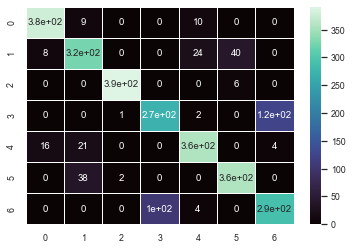

In [48]:
print_result(y_test, KNeighborsGridPredict)

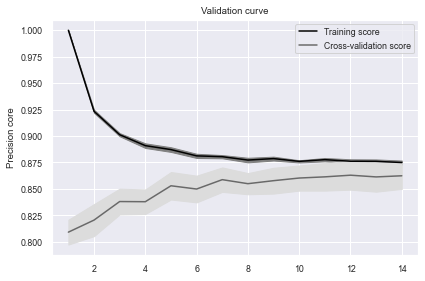

In [49]:
train_scores, valid_scores = validation_curve(
    KNeighborsGrid, X, y, 
    param_name="n_neighbors",
    param_range=parametrs["n_neighbors"], 
    cv=9, scoring="precision_macro"
)

plot_valid_train(train_scores, valid_scores, parametrs["n_neighbors"])

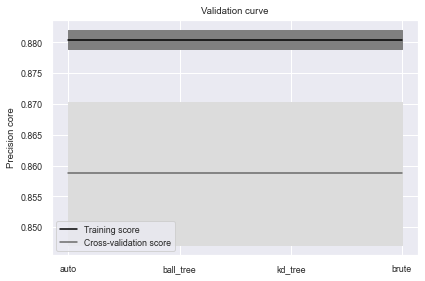

In [50]:
train_scores, valid_scores = validation_curve(
    KNeighborsGrid, X, y,
    param_name="algorithm",
    param_range=parametrs["algorithm"], 
    cv=9, scoring="precision_macro"
)

plot_valid_train(train_scores, valid_scores, parametrs["algorithm"])

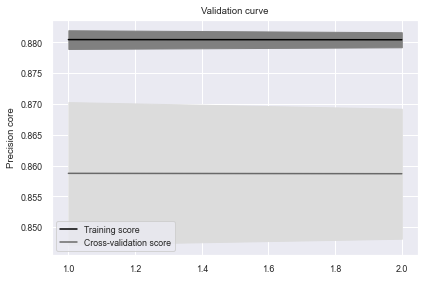

In [51]:
train_scores, valid_scores = validation_curve(
    KNeighborsGrid, X, y, 
    param_name="p",
    param_range=parametrs["p"], 
    cv=9, scoring="precision_macro"
)

plot_valid_train(train_scores, valid_scores, parametrs["p"])

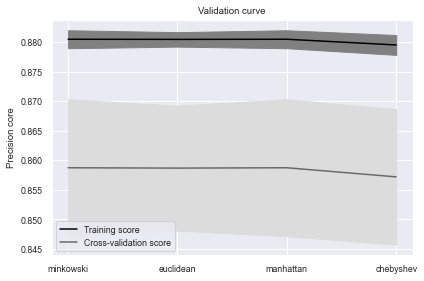

In [52]:
train_scores, valid_scores = validation_curve(
    KNeighborsGrid, X, y,
    param_name="metric",
    param_range=parametrs["metric"], 
    cv=9, scoring="precision_macro"
)

plot_valid_train(train_scores, valid_scores, parametrs["metric"])

Переобучение не наблюдается.

## Выводы об использовании RandomSearch и GridSearch:

1) Поиск по сетке работает медленнее случайного поиска. Так как оба метода поиска дают прирост качества (средняя оценка на кросс-валидации), то для первичной настройки гиперпараметров, возможно, лучше сначала пробовать случайный поиск из-за скорости работы. Если же не получается добиться желаемого качества, то можно использовать поиск по сетке.

2) Случайный поиск хоть и не является "информативным" методом (он не полагается на прошлые результаты оценки), он обычно находит лучшие значения, чем значения по умолчанию.

3) Поиск по сетке работает медленнее, но даёт результат лучше, чем случайный поиск.

4) Важно сказать, что настройка гиперпараметров не всегда является хорошим решением для увеличения качества, потому что она может привести к переобучению. Использование настройки с учётом кросс-валидации должно минимизировать этот риск, но он все равно имеет место быть.